#### Import needed packages

In [1]:
import json
import numpy as np
import pandas as pd
import pylab as pl
import re
import string
import nltk
from collections import Counter
stopwords = nltk.corpus.stopwords.words('english')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim import corpora, models
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

#### Import and prepare tweet data

In [2]:
tweet_files = ['#NetNeutrality/#NetNeutrality_2018-01-22.json', 'net/net_2018-01-22.json', '#NetNeutrality/#NetNeutrality_2018-01-23.json', 'net/net_2018-01-23.json', '#NetNeutrality/#NetNeutrality_2018-01-24.json', 'net/net_2018-01-24.json', '#NetNeutrality/#NetNeutrality_2018-01-25.json', 'net/net_2018-01-25.json', '#NetNeutrality/#NetNeutrality_2018-01-26.json', 'net/net_2018-01-26.json', '#NetNeutrality/#NetNeutrality_2018-01-27.json', 'net/net_2018-01-27.json', '#NetNeutrality/#NetNeutrality_2018-01-28.json', 'net/net_2018-01-28.json', '#NetNeutrality/#NetNeutrality_2018-01-29.json', 'net/net_2018-01-29.json', '#NetNeutrality/#NetNeutrality_2018-01-30.json', 'net/net_2018-01-30.json', '#NetNeutrality/#NetNeutrality_2018-01-31.json', 'net/net_2018-01-31.json', '#NetNeutrality/#NetNeutrality_2018-02-01.json', 'net/net_2018-02-01.json', '#NetNeutrality/#NetNeutrality_2018-02-02.json', 'net/net_2018-02-02.json', '#NetNeutrality/#NetNeutrality_2018-02-03.json', 'net/net_2018-02-03.json', '#NetNeutrality/#NetNeutrality_2018-02-04.json', 'net/net_2018-02-04.json', '#NetNeutrality/#NetNeutrality_2018-02-05.json', 'net/net_2018-02-05.json', '#NetNeutrality/#NetNeutrality_2018-02-06.json', 'net/net_2018-02-06.json', '#NetNeutrality/#NetNeutrality_2018-02-07.json', 'net/net_2018-02-07.json', '#NetNeutrality/#NetNeutrality_2018-02-08.json', 'net/net_2018-02-08.json', '#NetNeutrality/#NetNeutrality_2018-02-09.json', 'net/net_2018-02-09.json', '#NetNeutrality/#NetNeutrality_2018-02-10.json', 'net/net_2018-02-10.json', '#NetNeutrality/#NetNeutrality_2018-02-11.json', 'net/net_2018-02-11.json', '#NetNeutrality/#NetNeutrality_2018-02-12.json', 'net/net_2018-02-12.json', '#NetNeutrality/#NetNeutrality_2018-02-13.json', 'net/net_2018-02-13.json', '#NetNeutrality/#NetNeutrality_2018-02-14.json', 'net/net_2018-02-14.json', '#NetNeutrality/#NetNeutrality_2018-02-15.json', 'net/net_2018-02-15.json', '#NetNeutrality/#NetNeutrality_2018-02-16.json', 'net/net_2018-02-16.json', '#NetNeutrality/#NetNeutrality_2018-02-17.json', 'net/net_2018-02-17.json', '#NetNeutrality/#NetNeutrality_2018-02-18.json', 'net/net_2018-02-18.json', '#NetNeutrality/#NetNeutrality_2018-02-19.json', 'net/net_2018-02-19.json', '#NetNeutrality/#NetNeutrality_2018-02-20.json', 'net/net_2018-02-20.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

In [3]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets))                
    df['tweet_date'] = list(map(lambda tweet: tweet['created_at'], tweets))
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))                      
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))                
    df['name'] = list(map(lambda tweet: tweet['user']['name'], tweets))               
    df['description'] = list(map(lambda tweet: tweet['user']['description'], tweets))                
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
    df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))               
    df['user_location'] = list(map(lambda tweet: tweet['user']['location'] 
                        if tweet['place'] != None else '', tweets))
    df['tweet_location'] = list(map(lambda tweet: tweet['place']['full_name'] 
                        if tweet['place'] != None else '', tweets))
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    return df

In [4]:
df = populate_tweet_df(tweets)

In [5]:
df = df.drop_duplicates(["tweet_id"])

In [6]:
def parse_location(string):
    if (string.split(',')[-1] == ' USA'):
        return string.split(',')[0]
    else:
        return string.split(', ')[-1]
df['state'] = df['tweet_location'].map(parse_location)

In [7]:
statedict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [8]:
for key, value in statedict.items():
    df['state'] = df['state'].replace(key, value)

In [57]:
otherlocdict = {
        'Alberta': 'Outside US',
        'Algarrobos': 'Outside US',
        'Amherst Regional Middle School': 'Massachusetts',
        'Apulia': 'Outside US',
        'Argentina': 'Outside US',
        'Austria': 'Outside US',
        'Bahamas': 'Outside US',
        'Baja California': 'Outside US',
        'Barbados': 'Outside US',
        'Barcelona': 'Outside US',
        'Bavaria': 'Outside US',
        'Bayamón': 'Outside US',
        'Belgium': 'Outside US',
        'België': 'Outside US',
        'Berlin': 'Outside US',
        'Brasil': 'Outside US',
        'Brazil': 'Outside US',
        'British Columbia': 'Outside US',
        'California State Capitol Building': 'California',
        'Campania': 'Outside US',
        'Canada': 'Outside US',
        'Carolina Bay': 'North Carolina',
        'Caveat': 'Outside US',
        'Changwat Chon Buri': 'Outside US',
        'Channel Islands Harbor Green Navigation Light': 'California',
        'Chicago': 'Illinois',
        'Chihuahua': 'Outside US',
        'Chile': 'Outside US',
        'Colombia': 'Outside US',
        'Costa Rica': 'Outside US',
        'Cuba': 'Outside US',
        'Czech Republic': 'Outside US',
        'Davao Region': 'Outside US',
        'Denmark': 'Outside US',
        'Deutschland': 'Outside US',
        'Distrito Federal': 'Outside US',
        'Dovetail Brewing': 'Illinois',
        'Duluth MN-Superior WI': 'Minnesota',
        'East': 'Outside US',
        'Ecuador': 'Outside US',
        'El Salvador': 'Outside US',
        'England': 'Outside US',
        'Espanya': 'Outside US',
        'España': 'Outside US',
        'Finland': 'Outside US',
        'France': 'Outside US',
        'Frankfurt Airport': 'Outside US',
        'Germany': 'Outside US',
        'Hato Rey Sur': 'Puerto Rico',
        'Honduras': 'Outside US',
        'Hong Kong': 'Outside US',
        'Hungary': 'Outside US',
        'Iceland': 'Outside US',
        'India': 'Outside US',
        'Indonesia': 'Outside US',
        'Ireland': 'Outside US',
        'Isle of Man': 'Outside US',
        'Israel': 'Outside US',
        'Jamaica': 'Outside US',
        'Kingdom of Saudi Arabia': 'Outside US',
        'Kuala Lumpur Federal Territory': 'Outside US',
        'Lazio': 'Outside US',
        'Liguria': 'Outside US',
        'Lombardia': 'Outside US',
        'Lombardy': 'Outside US',
        'London': 'Outside US',
        'Los Angeles': 'California',
        'Luxembourg': 'Outside US',
        'Maldives': 'Outside US',
        'Manitoba': 'Outside US',
        'Marche': 'Outside US',
        'Massachusetts State House': 'Massachusetts',
        'Mordor': 'Outside US',
        'München': 'Outside US',
        'National Capital Region': 'District of Columbia',
        'Nederland': 'Colorado',
        'Nepal': 'Outside US',
        'New South Wales': 'Outside US',
        'New Zealand': 'Outside US',
        'Newfoundland and Labrador': 'Outside US',
        'Newseum - Knight Conference Center': 'District of Columbia',
        'Nigeria': 'Outside US',
        'Norge': 'Outside US',
        'Northern Essex Community College': 'Outside US',
        'Northern Ireland': 'Outside US',
        'Nova Scotia': 'Outside US',
        'Nuevo León': 'Outside US',
        'Nürnberg': 'Outside US',
        'Odessa High School': 'Texas',
        'Ontario': 'Outside US',
        'Osaka': 'Outside US',
        'Paradise': 'Outside US',
        "People's Republic of China": 'Outside US',
        'Perlis': 'Louisiana',
        'Piedmont': 'Outside US',
        'Playa': 'Outside US',
        'Poland': 'Outside US',
        'Portland': 'Oregon',
        'Queens': 'New York',
        'Queensland': 'Outside US',
        'Quintana Roo': 'Outside US',
        'Québec': 'Outside US',
        'Republic of Korea': 'Outside US',
        'Rhode Island State House': 'Rhode Island',
        'Rochester': 'New York',
        'Romania': 'Outside US',
        'Russia': 'Outside US',
        'Sacramento State': 'California',
        'Sarawak': 'Outside US',
        'Saskatchewan': 'Outside US',
        'Schleswig-Holstein': 'Outside US',
        'Scotland': 'Outside US',
        'Seattle': 'Washington',
        'Singapore': 'Outside US',
        'South Africa': 'Outside US',
        'Spain': 'Outside US',
        'Sri Lanka': 'Outside US',
        'Suomi': 'Outside US',
        'Sweden': 'Outside US',
        'Switzerland': 'Outside US',
        'Taiwan': 'Outside US',
        'Tasmania': 'Outside US',
        'Thailand': 'Outside US',
        'The Netherlands': 'Outside US',
        'The Urban Hive': 'California',
        'Tokyo': 'Outside US',
        'Tokyo 23 ward': 'Outside US',
        'Toronto': 'Outside US',
        'Trinidad and Tobago': 'Outside US',
        'United Arab Emirates': 'Outside US',
        'United Kingdom': 'Outside US',
        'University of Glasgow': 'Outside US',
        'University of La Verne': 'California',
        'VCU Pocahontas Building': 'Virginia',
        'Veneto': 'Outside US',
        'Victoria': 'Outside US',
        'Vintage Marina C19': 'California',
        'Wales': 'Outside US',
        'Washington D.C.': 'District of Columbia',
        'Yamaguchi': 'Outside US'
}

In [58]:
for key, value in otherlocdict.items():
    df['state'] = df['state'].replace(key, value)

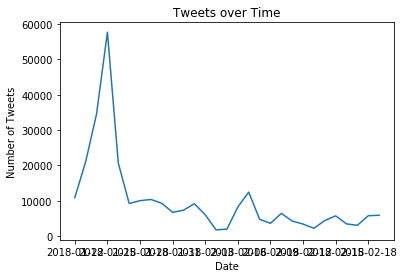

In [11]:
# Convert tweet date to a datetime object
df['tweet_date'] = pd.to_datetime(df['tweet_date'],  errors='raise')
df.groupby(df['tweet_date'].dt.date).size().plot()
plt.title('Tweets over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

### Clean, Tokenize and Vectorize Text Data for Analysis

In [12]:
tweettext = df.text.tolist()

In [13]:
def clean_tweet(tweet):
    # Remove RT (retweet signal)
    tweet = re.sub('RT @', '@', tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*','', tweet)
    # Remove URLs
    tweet = re.sub(r'https?:\/\/.*\/\w*','', tweet)
    # Remove puncutation
    tweet = re.sub(r'[' + string.punctuation + ']+', ' ', tweet)
    # Tokenize text
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    # Remove stopwords and single characters
    tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 1]
    return tokens

In [14]:
cleaned_tweets = []
for tweet in tweettext:
    cleaned_tweets.append(clean_tweet(tweet))

In [15]:
len(cleaned_tweets), len(df)

(291445, 291445)

In [16]:
df['cleaned_text'] = cleaned_tweets

In [17]:
df.head()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt,state,cleaned_text
0,955590854734958592,2018-01-22 23:59:48,813084079180709888,SamanthaRblxYT,sam🦄,I LOVE MA GURPS!! @YourLilPotato & @Little_Sno...,RT @MatthewBender9: #NetNeutrality How it’s go...,1291,0,,,NaN,NaN,,"[matthewbender, netneutrality, how, going, loo..."
1,955590762271526912,2018-01-22 23:59:26,830465545275371521,margeholmes6162,Marj,,RT @DeadpoolResists: Montana becomes first sta...,475,0,,,NaN,NaN,,"[deadpoolresists, montana, becomes, first, sta..."
2,955590754033946634,2018-01-22 23:59:24,3246707126,AllMghtyLantern,AllMightyLantern,"Lover of all things comics, games, animation, ...",RT @fightfortheftr: We are ONE VOTE AWAY from ...,839,0,,,NaN,NaN,,"[fightfortheftr, we, one, vote, away, winning,..."
3,955590534789124096,2018-01-22 23:58:32,786420072730333184,pyrrpro55,Pyrrhis Productions,Formerly Simulation Studios!,RT @freepress: Don't be fooled: Your activism ...,35,0,,,NaN,NaN,,"[freepress, don, fooled, your, activism, suppo..."
4,955590495950041088,2018-01-22 23:58:22,1603164476,bzaenglein,Barbara Zaenglein,#Resist #Notmypresident. #NetNeutrality #Pence...,RT @freepress: We're suing the FCC to save #Ne...,36,0,,,NaN,NaN,,"[freepress, we, suing, fcc, save, netneutralit..."


In [18]:
cleaned_texts = df.cleaned_text.apply(lambda x: ' '.join(x))

In [19]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))  
transformed = vectorizer.fit_transform(cleaned_texts.values)
features = vectorizer.get_feature_names()

In [20]:
transformed.shape

(291445, 345471)

### Clustering - What are the top text clusters?

In [21]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
kmeans.fit(transformed)
clusters = kmeans.labels_.tolist()
df['cluster_id'] = clusters

df.cluster_id.value_counts()

0    243787
1     24264
3     11778
2      6393
4      5223
Name: cluster_id, dtype: int64

In [22]:
# sort cluster centers by proximity to centroid
centroids_order = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order[i, :10]:
        print('\t{}'.format(features[idx]))



Top terms in cluster 0:

	neutrality
	net
	net neutrality
	netneutrality
	fcc
	king
	burger
	state
	burger king
	montana


Top terms in cluster 1:

	we whopper
	explain repeal
	how would
	would explain
	burgerking how
	watch video
	whopper watch
	neutrality we
	how
	watch


Top terms in cluster 2:

	jackedyotweets the
	government take
	jackedyotweets
	neutrality guns
	guns
	the government
	away net
	take away
	away
	government


Top terms in cluster 3:

	lessened last
	cant forget
	months cant
	forget close
	lessened
	coverage lessened
	netneutrality coverage
	last couple
	though netneutrality
	couple months


Top terms in cluster 4:

	montana democratic
	service providers
	democratic
	internet service
	service
	providers
	signed executive
	order mandating
	mandating internet
	mandating


### Topic Modeling - Two Algorithmic Approaches

#### LDA (Latent Dirichlet Allocation) Models

In [23]:
lemma = WordNetLemmatizer()

def lemmatize(text):
    return ' '.join(lemma.lemmatize(word) for word in text.split())

texts = [text for text in cleaned_texts.values if len(text) > 1]
lemmatized_texts = [lemmatize(text).split() for text in texts]

In [24]:
dictionary = corpora.Dictionary(lemmatized_texts)
terms_matrix = [dictionary.doc2bow(doc) for doc in lemmatized_texts]

In [25]:
ldamodel = models.ldamodel.LdaModel(
    terms_matrix, num_topics=20, id2word=dictionary, passes=5)

In [26]:
for topic in ldamodel.show_topics(num_topics=10, formatted=False, num_words=10):
    print("Top terms in topic {}: ".format(topic[0]))
    words = [w for (w, val) in topic[1]]
    print(words)

Top terms in topic 10: 
['colesprouse', 'healthcare', 'if', 'business', 'want', 'collusion', 'still', 'netneutrality', 'hey', 'you']
Top terms in topic 14: 
['government', 'ajitpaifcc', 'netneutrality', 'support', 'without', 'legislature', 'can', 'february', 'passed', 'smug']
Top terms in topic 6: 
['netneutrality', 'this', 'to', 'back', 'thank', 'the', 'way', 'leading', 'issue', 'yet']
Top terms in topic 11: 
['netneutrality', 'fightfortheftr', 'need', 'one', 'save', 'onemorevote', 'senate', 'vote', 'cra', 'we']
Top terms in topic 17: 
['state', 'net', 'neutrality', 'new', 'via', 'order', 'fcc', 'eff', 'regulator', 'governor']
Top terms in topic 15: 
['the', 'netneutrality', 'fight', 'open', 'feb', 'join', 'rt', 'change', 'state', 'community']
Top terms in topic 13: 
['though', 'coverage', 'rule', 'fcc', 'killing', 'repealed', 'first', 'add', 'common', 'after']
Top terms in topic 7: 
['away', 'cable', 'take', 'netneutrality', 'love', 'co', 'joining', 'show', 'petition', 'medium']
Top 

#### NMF (Non-negative Matrix Factorization) Model

In [27]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = 1000
no_topics = 10
no_top_words = 10

In [28]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(transformed)

In [29]:
display_topics(nmf, features, no_top_words)

Topic 0:
we whopper how would explain repeal would explain burgerking how watch video whopper watch neutrality we watch how
Topic 1:
cant forget forget close months cant lessened last netneutrality coverage coverage lessened lessened last couple though netneutrality couple months
Topic 2:
jackedyotweets the government take jackedyotweets neutrality guns guns away net the government take away away government
Topic 3:
montana democratic signed executive service providers internet service order mandating democratic gov mandating internet mandating gov steve bullock signed
Topic 4:
first state first montana becomes becomes first becomes state montana fcc repeal neutrality rules state add
Topic 5:
cared net cared everyone cared blessedzvy remember blessedzvy remember everyone remember everyone net neutrality neutrality
Topic 6:
pass we need permanent need law we permanent netneutrality need permanent law congressional resolution even
Topic 7:
needs netneutrality music needs music needs stan

### Sentiment Analysis

#### Sentiment Analysis using TextBlob Pattern Analyzer

In [30]:
def get_tweet_sentiment(tweet):
    return TextBlob(tweet).sentiment.polarity

In [31]:
df['sentiment'] = df.cleaned_text.apply(lambda x: get_tweet_sentiment(' '.join(x)))

In [32]:
hist, edges = np.histogram(df.sentiment.values, bins=np.arange(-1, 1, 0.1))

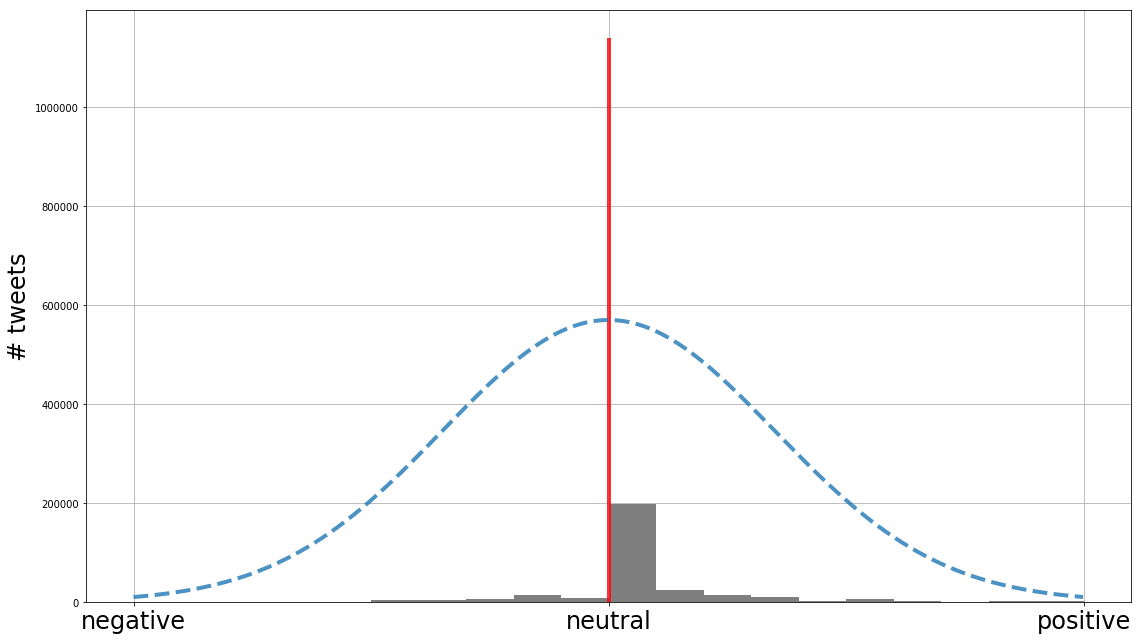

In [33]:
from scipy.stats import norm

fig, ax = pl.subplots(figsize=(16, 9))
df.sentiment.hist(ax=ax, bins=20, color='k', alpha=0.5)
# ax.bar(edges, hist, width=width, color='k', alpha=0.5)
ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['negative', 'neutral', 'positive'], fontsize=24)
ax.set_ylabel('# tweets', fontsize=24)
x = np.arange(-1, 1, 0.001)
ax.plot(x, norm.pdf(x, 0, 0.35) * 500000, '--', linewidth=4, alpha=0.8)
ax.vlines(0, 0, 1140000, color='r', linewidth=4, linestyle='-', alpha=0.8)
pl.tight_layout()
pl.show()

In [34]:
THR = 0.2
neg = df[df.sentiment < -THR]
pos = df[df.sentiment > THR]
neg_text = ' '.join(neg.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')
pos_text = ' '.join(pos.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')

In [35]:
Counter(neg_text.split(' ')).most_common()[1:10]

[('neutrality', 4201),
 ('netneutrality', 4061),
 ('fake', 1811),
 ('fcc', 1791),
 ('amp', 1306),
 ('repeal', 1213),
 ('internet', 1120),
 ('comments', 1099),
 ('at', 1050)]

In [36]:
Counter(pos_text.split(' ')).most_common()[1:10]

[('neutrality', 15099),
 ('net', 14481),
 ('burger', 6053),
 ('king', 5971),
 ('fcc', 4724),
 ('repeal', 4283),
 ('good', 3921),
 ('fightfortheftr', 3648),
 ('we', 2997)]

In [37]:
for t in df[df.sentiment == df.sentiment.min()].text[:5]:
    print(t + '\n')

RT @miketimmons: @AjitPaiFCC You are a terrible person #NetNeutrality

@AjitPaiFCC You are a terrible person #NetNeutrality

Curbing #netneutrality would be the worst thing for internet.   #simulatedworld  https://t.co/qty1abHt20

RT @Nasty_Woman1: When almost all People want this done it should be done IF we had Politicians in DC who did what we elected them to do, w…

RT @Nasty_Woman1: When almost all People want this done it should be done IF we had Politicians in DC who did what we elected them to do, w…



In [38]:
for t in df[df.sentiment == df.sentiment.max()].text[:5]:
    print(t + '\n')

This. Is. AWESOME!

#NetNeutrality https://t.co/3wQXB9UvAp

Between @SenatorTester's no vote on the CR this AM, and @GovernorBullock's excellent #NetNeutrality executive order… https://t.co/sh5TDb5ls0

@GovernorBullock is leading the nation and doing what is obviously best for Montanans, thank you!! Hopefully other… https://t.co/09CzwBFcNv

R/T Are there #Geminis that are seeking an awesome 📖to read.  Download or Order the Print Copy, Now, of the mystery… https://t.co/DBPR8bPK6p

Excellent stuff from @Cablefax's resident columnist @SteveEffros. re: #NetNeutrality . https://t.co/FNSwOlwP0D



#### Sentiment Analysis using TextBlob Naive Bayes Analyzer

In [39]:
from textblob.sentiments import NaiveBayesAnalyzer

def get_nbtweet_sentiment(tweet):
    return TextBlob(tweet, analyzer=NaiveBayesAnalyzer()).sentiment.polarity

In [40]:
df['nbsentiment'] = df.cleaned_text.apply(lambda x: get_tweet_sentiment(' '.join(x)))

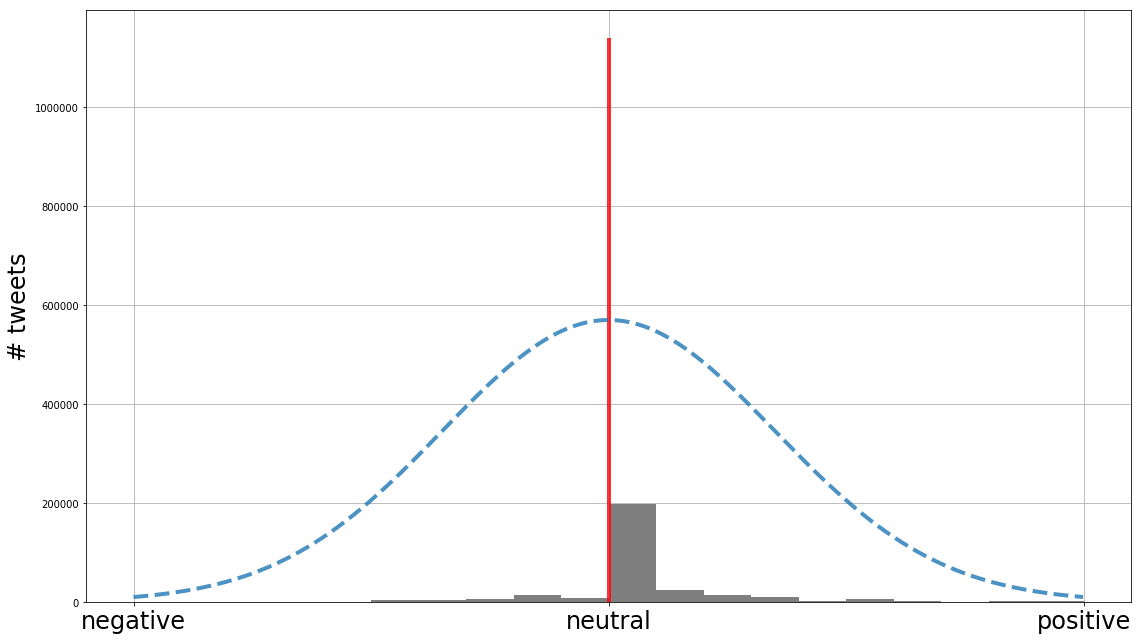

In [41]:
hist, edges = np.histogram(df.nbsentiment.values, bins=np.arange(-1, 1, 0.1))
fig, ax = pl.subplots(figsize=(16, 9))
df.nbsentiment.hist(ax=ax, bins=20, color='k', alpha=0.5)
# ax.bar(edges, hist, width=width, color='k', alpha=0.5)
ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['negative', 'neutral', 'positive'], fontsize=24)
ax.set_ylabel('# tweets', fontsize=24)
x = np.arange(-1, 1, 0.001)
ax.plot(x, norm.pdf(x, 0, 0.35) * 500000, '--', linewidth=4, alpha=0.8)
ax.vlines(0, 0, 1140000, color='r', linewidth=4, linestyle='-', alpha=0.8)
pl.tight_layout()
pl.show()

In [42]:
nbneg = df[df.nbsentiment < -THR]
nbpos = df[df.nbsentiment > THR]
nbneg_text = ' '.join(nbneg.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')
nbpos_text = ' '.join(nbpos.cleaned_text.apply(lambda x: ' '.join(x))).replace('iot', '')

In [43]:
Counter(nbneg_text.split(' ')).most_common()[1:10]

[('neutrality', 4201),
 ('netneutrality', 4061),
 ('fake', 1811),
 ('fcc', 1791),
 ('amp', 1306),
 ('repeal', 1213),
 ('internet', 1120),
 ('comments', 1099),
 ('at', 1050)]

In [44]:
Counter(nbpos_text.split(' ')).most_common()[1:10]

[('neutrality', 15099),
 ('net', 14481),
 ('burger', 6053),
 ('king', 5971),
 ('fcc', 4724),
 ('repeal', 4283),
 ('good', 3921),
 ('fightfortheftr', 3648),
 ('we', 2997)]

In [45]:
for t in df[df.nbsentiment == df.nbsentiment.min()].text[:5]:
    print(t + '\n')

RT @miketimmons: @AjitPaiFCC You are a terrible person #NetNeutrality

@AjitPaiFCC You are a terrible person #NetNeutrality

Curbing #netneutrality would be the worst thing for internet.   #simulatedworld  https://t.co/qty1abHt20

RT @Nasty_Woman1: When almost all People want this done it should be done IF we had Politicians in DC who did what we elected them to do, w…

RT @Nasty_Woman1: When almost all People want this done it should be done IF we had Politicians in DC who did what we elected them to do, w…



In [46]:
for t in df[df.nbsentiment == df.nbsentiment.max()].text[:5]:
    print(t + '\n')

This. Is. AWESOME!

#NetNeutrality https://t.co/3wQXB9UvAp

Between @SenatorTester's no vote on the CR this AM, and @GovernorBullock's excellent #NetNeutrality executive order… https://t.co/sh5TDb5ls0

@GovernorBullock is leading the nation and doing what is obviously best for Montanans, thank you!! Hopefully other… https://t.co/09CzwBFcNv

R/T Are there #Geminis that are seeking an awesome 📖to read.  Download or Order the Print Copy, Now, of the mystery… https://t.co/DBPR8bPK6p

Excellent stuff from @Cablefax's resident columnist @SteveEffros. re: #NetNeutrality . https://t.co/FNSwOlwP0D



#### Compare sentiments by state

In [59]:
df2 = df[['sentiment', 'state']]
df3 = df2.pivot_table(index='state', aggfunc='mean')
df3 = df3.drop(['', 'Burger King', 'IHOP', 'United States', 'Yogurtland'])

In [60]:
df3

,sentiment
state,
Alabama,0.080655
Alaska,0.056374
Arizona,0.017437
Arkansas,0.018033
California,0.069014
Colorado,0.073561
Connecticut,-0.001046
Delaware,0.050606
District of Columbia,0.092378
